In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import img_to_array # is this deprecated? maybe look it up
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pathlib
import random as rn
import numpy as np

In [7]:
data_dir="work/keras/carclassfication_model/data/car_data/test"
image_size = (224, 224)
batch_size = 50
inputs = keras.Input(shape=(224, 224, 3))

In [17]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=42,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

# class_names = train_ds.class_names

Found 8041 files belonging to 196 classes.
Using 6433 files for training.
Using 1608 files for validation.


In [18]:
base_model = ResNet50(weights='imagenet', input_tensor=inputs, include_top=True)
last_layer = base_model.layers[-2].output
out = Dense(units = len(train_ds.class_names), activation = 'softmax', name = 'ouput')(last_layer)

new_base_model = Model(inputs = inputs, outputs = out)

for layer in new_base_model.layers[:-25]:
  layer.trainable = False

model = Model(inputs = inputs, outputs = out)

model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

Epoch 1/5
129/129 [==============================] - 984s 8s/step - loss: 3.9854 - accuracy: 0.1632 - val_loss: 8.3493 - val_accuracy: 0.0951
Epoch 2/5
129/129 [==============================] - 668s 5s/step - loss: 1.6728 - accuracy: 0.5554 - val_loss: 2.8012 - val_accuracy: 0.3228
Epoch 3/5
129/129 [==============================] - 693s 5s/step - loss: 0.7008 - accuracy: 0.8107 - val_loss: 2.1913 - val_accuracy: 0.4521
Epoch 4/5
129/129 [==============================] - 678s 5s/step - loss: 0.2642 - accuracy: 0.9381 - val_loss: 2.0083 - val_accuracy: 0.5062
Epoch 5/5
129/129 [==============================] - 649s 5s/step - loss: 0.1149 - accuracy: 0.9773 - val_loss: 1.8460 - val_accuracy: 0.5460


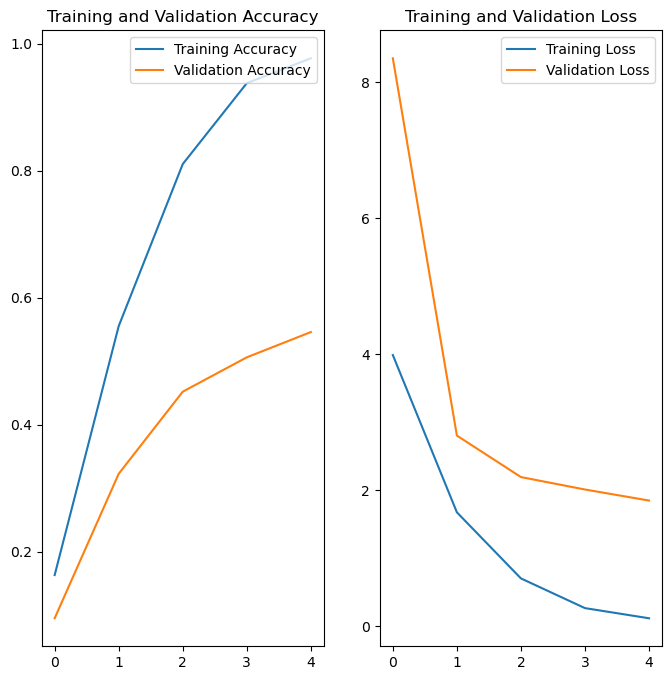

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
class_names = train_ds.class_names
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "work/keras/carclassfication_model/data/car_data/test_subset1",
    seed=66,  # test across diff seed values
    image_size=image_size,
    batch_size=batch_size,
)
model.evaluate(test_ds)

Found 1495 files belonging to 36 classes.


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/conda/lib/python3.10/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 196) are incompatible


In [49]:
car_path = []
# Grab random car from validation ds
class_names = list(train_ds.class_names)
validation_path = pathlib.Path("work/keras/carclassfication_model/data/car_data/test")
valid = list(validation_path.glob('*/*'))
rn_car = rn.randint(0, len(valid))
car = valid[rn_car]

# Display actual image path
print("Actual car {}".format(car))

# Load image to array
image = load_img(car, target_size=image_size)
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
temp = plt.imread(car)

# Plot image
# plt.imshow(temp)
# plt.show()

# Preprocess and predict image
image = keras.applications.resnet50.preprocess_input(image)
predictions = model.predict(image)
score = tf.nn.softmax(predictions[0])
print(
  "Prediction: {} with a {:.2f} percent confidence."
  .format(class_names[np.argmax(score)], 100 * np.max(score)))

Actual car work/keras/carclassfication_model/data/car_data/test/Rolls-Royce_Phantom_Drophead_Coupe_Convertible_2012/06645.jpg
1/1 [==============================] - 0s 75ms/step
Prediction: Rolls-Royce_Phantom_Drophead_Coupe_Convertible_2012 with a 1.25 percent confidence.
